# Test Overlap between sources in a blend

In [1]:
# Import Packages and setup
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
from lsst.utils import getPackageDir
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)
plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)
dlogger = logging.getLogger("deblender")
dlogger.setLevel(logging.INFO)

In [2]:
# Load the data
dataPath = os.path.abspath(os.path.join(lsst.utils.getPackageDir("testdata_deblender"), 'sim_data'))
filters = ["u", "g", "r", "i", "z", 'y']
imgFilename = os.path.join(dataPath, "test1/{0}_{1}.fits")
catFilename = os.path.join(dataPath, "test1/det_merge.fits")
simFilename = os.path.join(dataPath, "test1/catalog_true.fits")

expDb = proximal.ExposureDeblend(filters, imgFilename, catFilename, simFilename, useExactPeaks=True)
#pidx = 3
#condition = (expDb.mergedTable["peaks"]<=10) & (expDb.mergedTable["peaks"]>1)
pidx = 6
condition = None#(expDb.mergedTable["peaks"]<=5) & (expDb.mergedTable["peaks"]>1)
footprint, peaks = expDb.getParentFootprint(parentIdx=pidx, condition=condition, display=False)
deblend = proximal.DeblendedParent(expDb, footprint, peaks)

INFO:lsst.meas.deblender.proximal:Total parents: 9
INFO:lsst.meas.deblender.proximal:Unblended sources: 4
INFO:lsst.meas.deblender.proximal:Sources with multiple peaks: 5


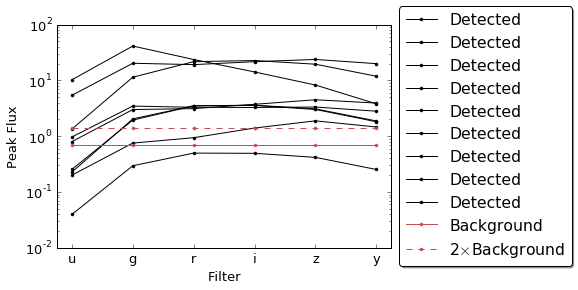

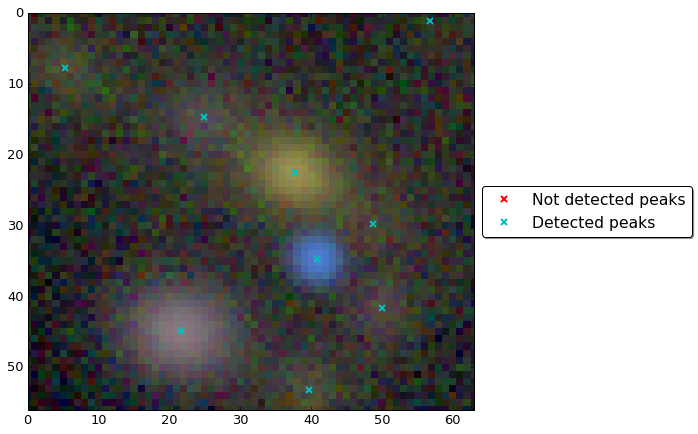

In [3]:
# Build a table of peaks detected by the pipeline
peakTable = sim.buildFootprintPeakTable(footprint, filters, peaks=peaks)
# Estimate the noise in the image
avgNoise = sim.getNoise(expDb.calexps)
simTable,idx, unmatchedTable = sim.matchFootprintToRef(footprint, peakTable, expDb.simTable,
                                                        filters,avgNoise=avgNoise, expDb=expDb,)
# Calculate the flux for isolated (non-blended) sources
sim.calculateIsolatedFlux(filters, expDb, peakTable, simTable, avgNoise)

In [4]:
%time dbr = sim.deblendFootprintOld(filters, expDb, footprint, peakTable)

CPU times: user 195 ms, sys: 10.8 ms, total: 205 ms
Wall time: 205 ms


In [5]:
peakCoords = np.array([simTable["x"],simTable["y"]]).T
glmm = expDb.deblendParent(
    condition=condition,
    parentIdx=pidx,
    display=False,
    maxiter=300,
    #min_iter=20,
    strict_constraints="M",
    constraints="S",
    usePsf=False,
    psfThresh=3e-3,
    e_rel=1e-2,
    monotonicUseNearest=True,
    l0_thresh=.35,
    algorithm="GLMM",
)

/Users/fred/projects/proxmin/proxmin/proximal.py:60: RuntimeWarning: invalid value encountered in true_divide
  return X / np.sum(X, axis=axis, keepdims=True)
INFO:proxmin.algorithms:Completed 300 iterations
INFO:lsst.meas.deblender.proximal:Total Runtime: 3.70 s


In [6]:
glmmPsf = expDb.deblendParent(
    condition=condition,
    parentIdx=pidx,
    display=False,
    maxiter=300,
    #min_iter=20,
    strict_constraints="M",
    constraints="S",
    usePsf=True,
    psfThresh=3e-3,
    e_rel=1e-2,
    monotonicUseNearest=True,
    l0_thresh=.35,
    algorithm="GLMM",
)

INFO:deblender.operators:Total psf pixels: 45
INFO:deblender.operators:Total psf pixels: 45
INFO:deblender.operators:Total psf pixels: 45
INFO:deblender.operators:Total psf pixels: 45
INFO:deblender.operators:Total psf pixels: 45
INFO:deblender.operators:Total psf pixels: 45
/Users/fred/projects/proxmin/proxmin/proximal.py:60: RuntimeWarning: invalid value encountered in true_divide
  return X / np.sum(X, axis=axis, keepdims=True)
INFO:proxmin.algorithms:Completed 300 iterations
INFO:lsst.meas.deblender.proximal:Total Runtime: 12.48 s


In [7]:
oldTemplates = sim.getODBTemplates(footprint, dbr, display=False)
simTemplates = sim.getSimTemplates(simTable, filters, footprint=footprint, display=False)
newTemplates = glmm.getAllTemplates()
newApportioned = glmm.getFluxPortionTemplates()
psfTemplates = glmmPsf.getAllTemplates()

INFO:lsst.meas.deblender.display:Peak 0


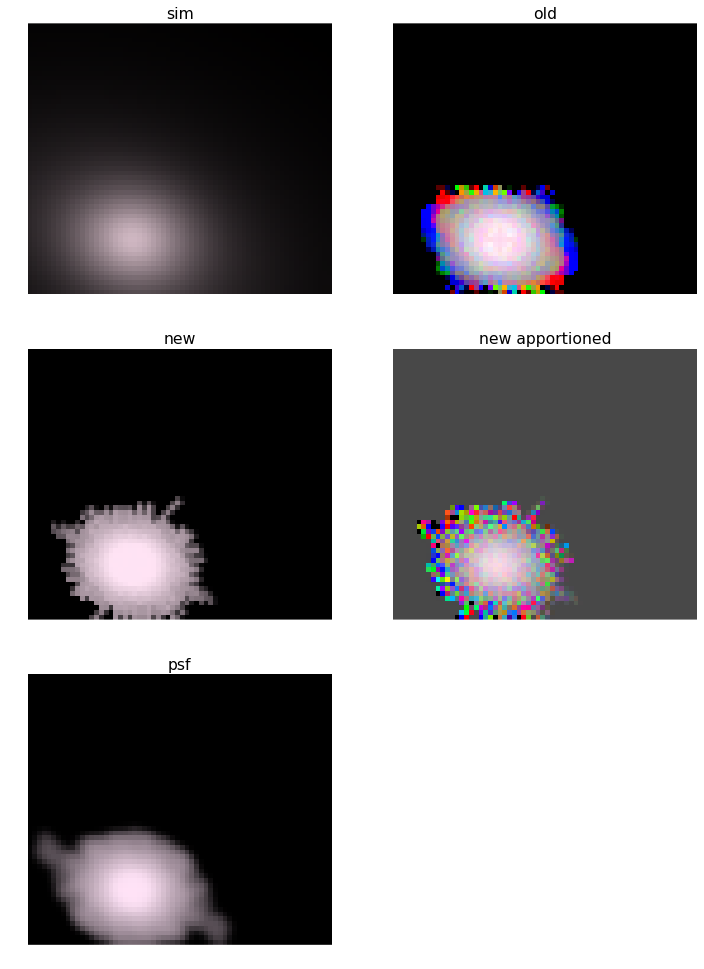

INFO:lsst.meas.deblender.display:Peak 1


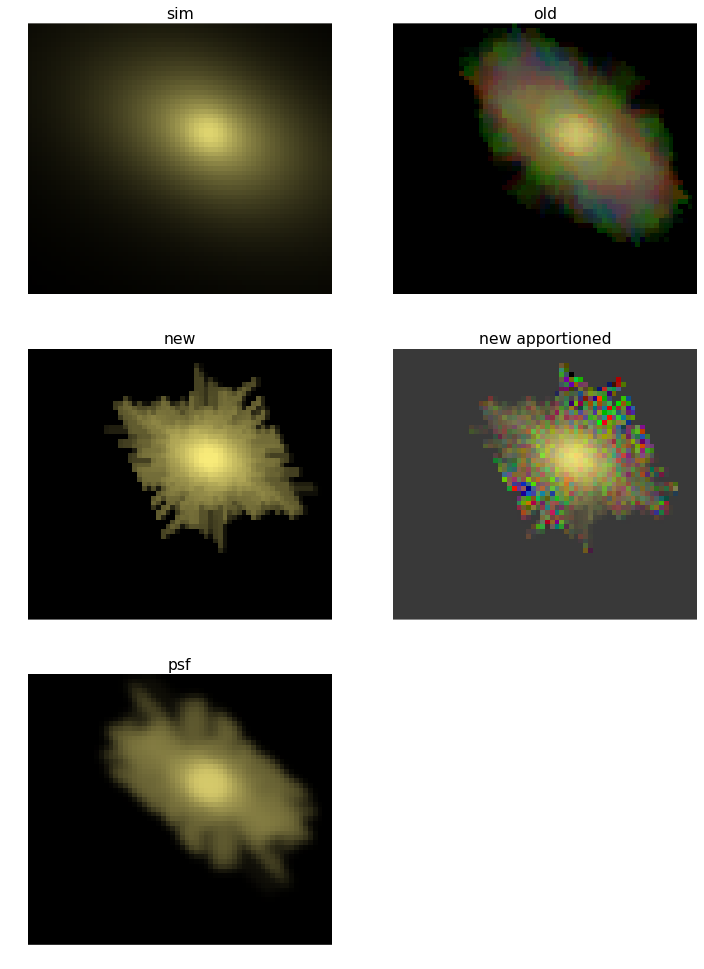

INFO:lsst.meas.deblender.display:Peak 2


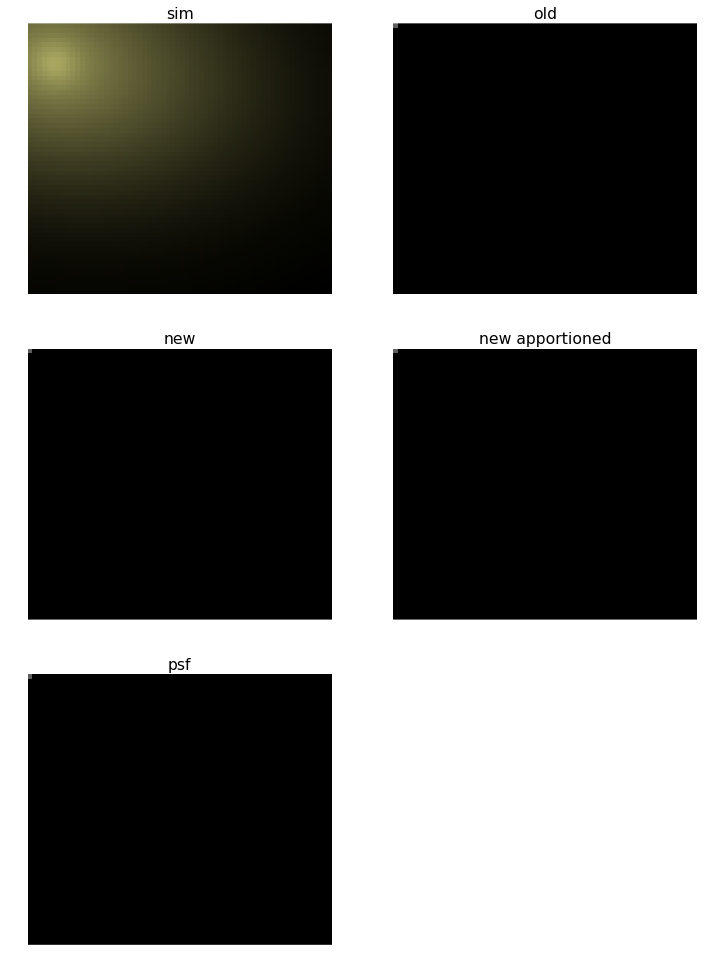

INFO:lsst.meas.deblender.display:Peak 3


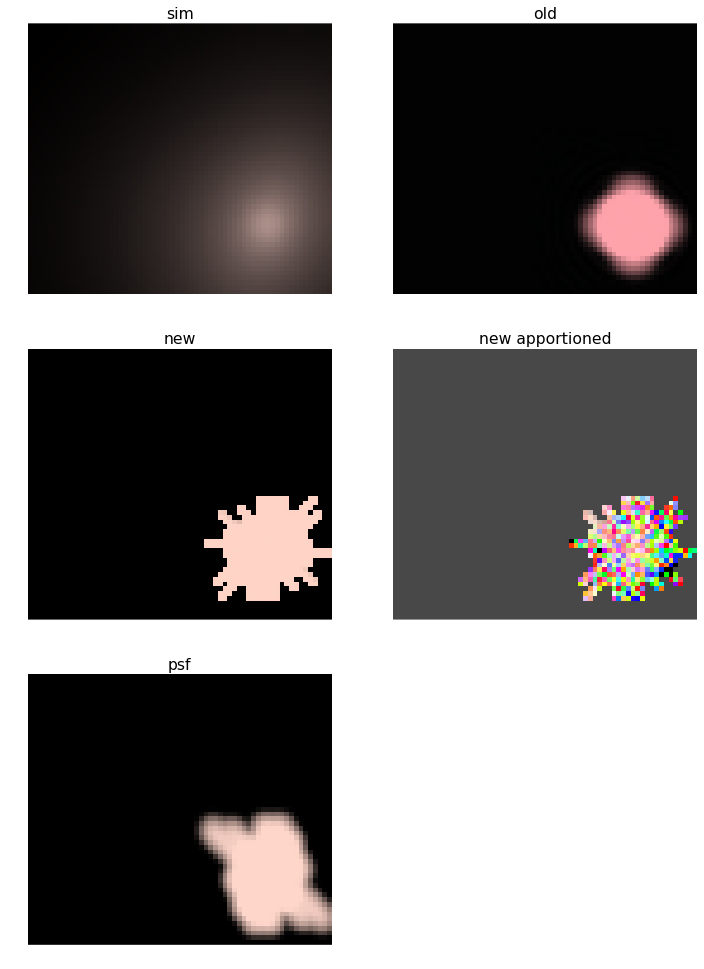

INFO:lsst.meas.deblender.display:Peak 4


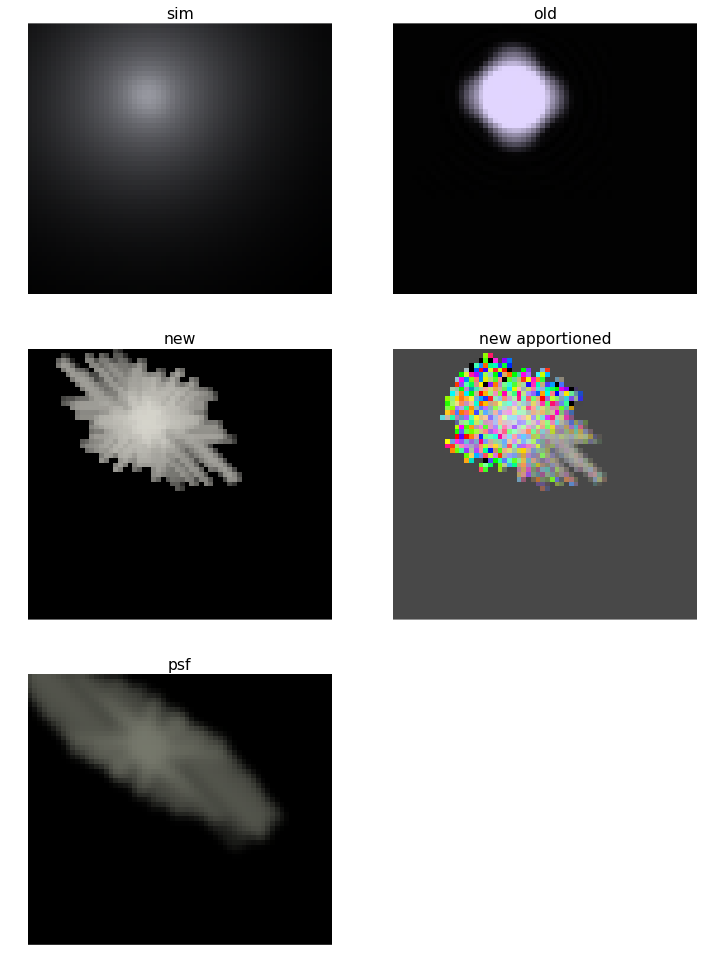

INFO:lsst.meas.deblender.display:Peak 5


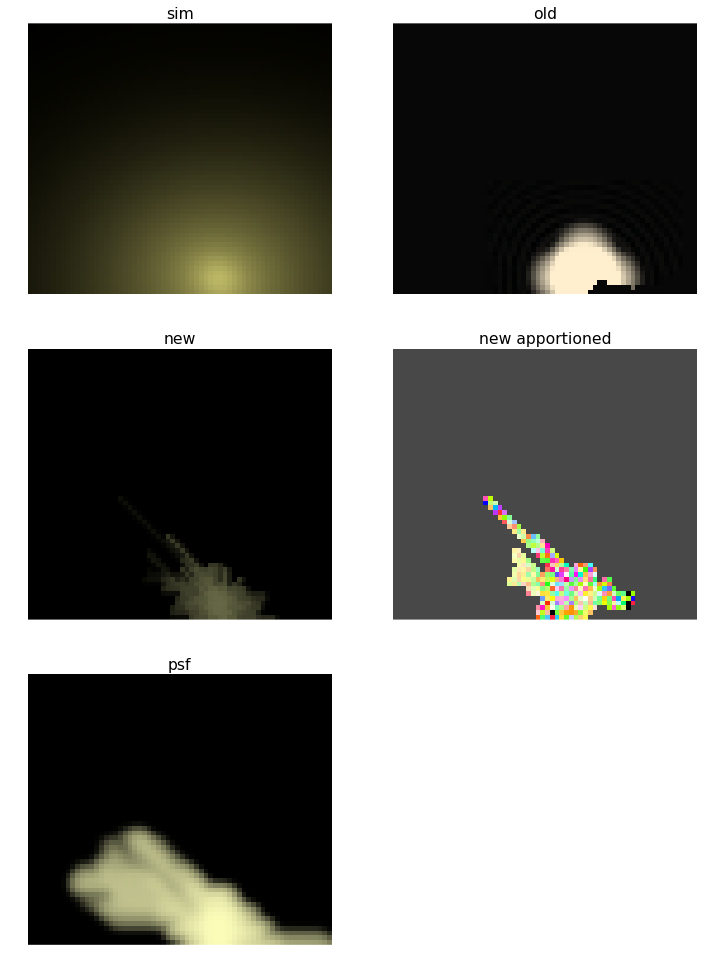

INFO:lsst.meas.deblender.display:Peak 6


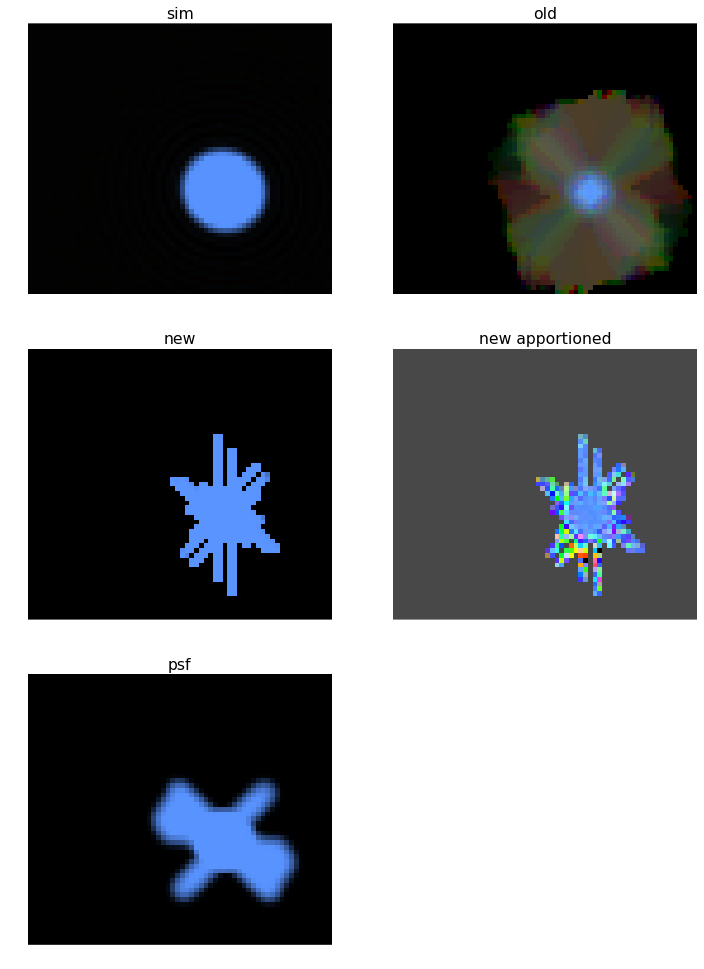

INFO:lsst.meas.deblender.display:Peak 7


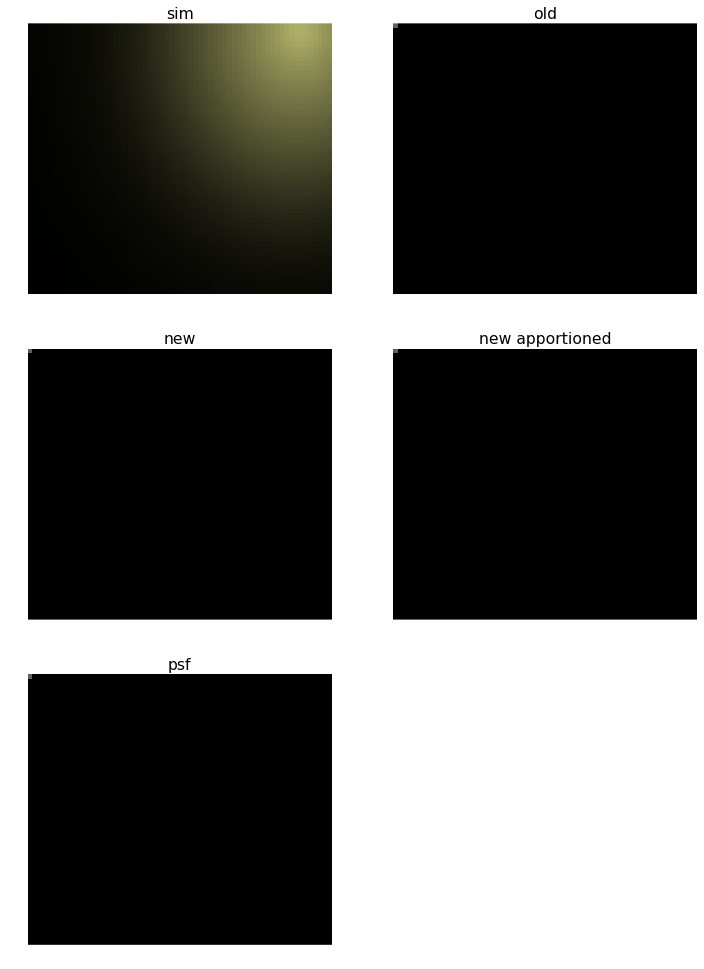

INFO:lsst.meas.deblender.display:Peak 8


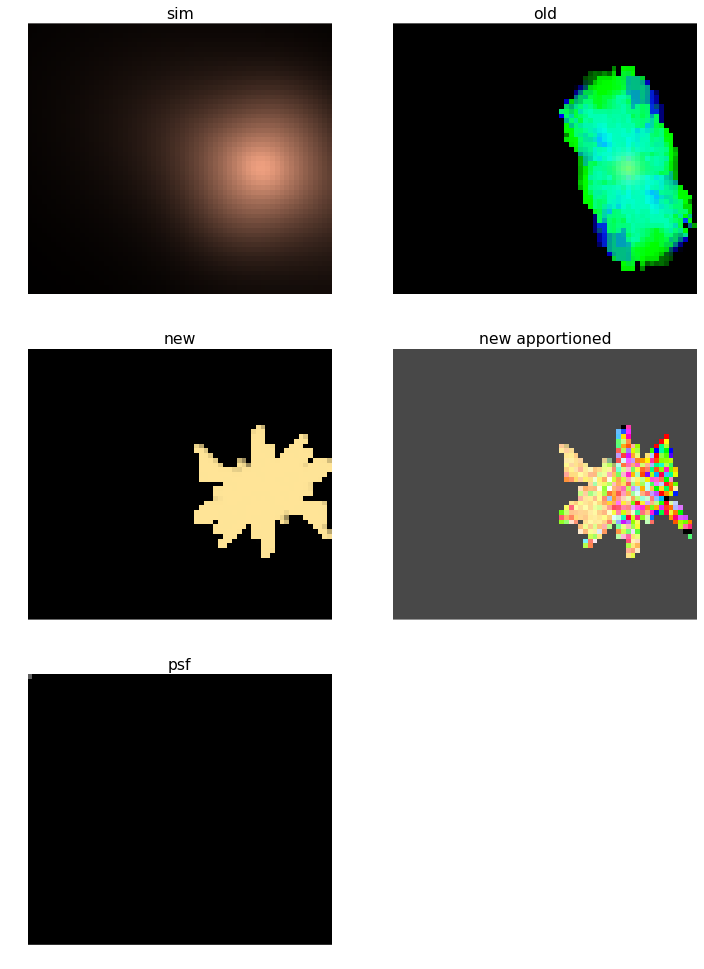

In [8]:
display.plotAllTemplates(OrderedDict([
    ("sim", simTemplates),
    ("old", oldTemplates),
    #("new", debTemplates),
    #("new apportioned", debApportioned),
    ("new", newTemplates),
    ("new apportioned", newApportioned),
    ("psf", psfTemplates)
]), columns=2)

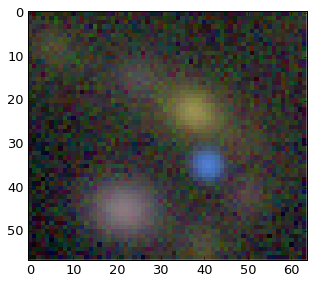

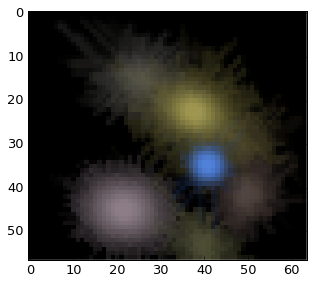

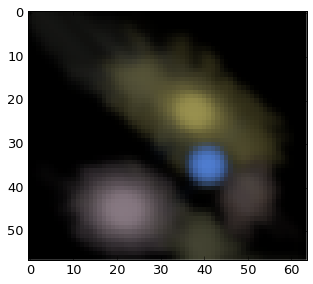

In [10]:
calImg = np.array([calexp[footprint.getBBox()].getMaskedImage().getImage().getArray()
                                 for calexp in expDb.calexps])
display.plotColorImage(calImg);
display.plotColorImage(glmm.model);
display.plotColorImage(glmmPsf.model);

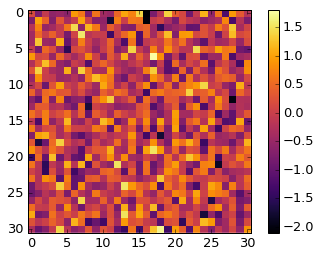

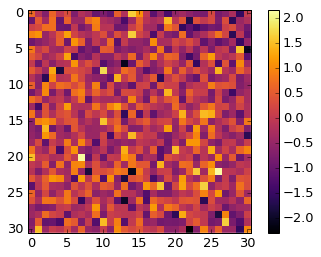

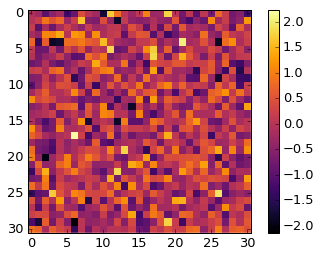

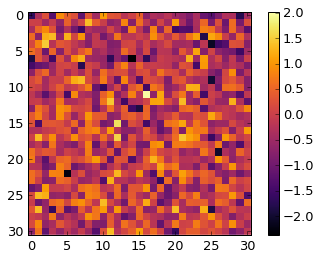

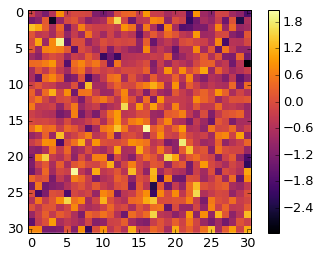

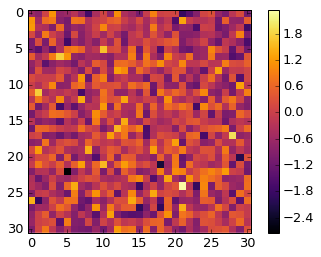

In [9]:
diff = glmm.model - glmm.data
for fidx, f in enumerate(filters):
    plt.imshow(diff[fidx])
    plt.colorbar()
    plt.show()

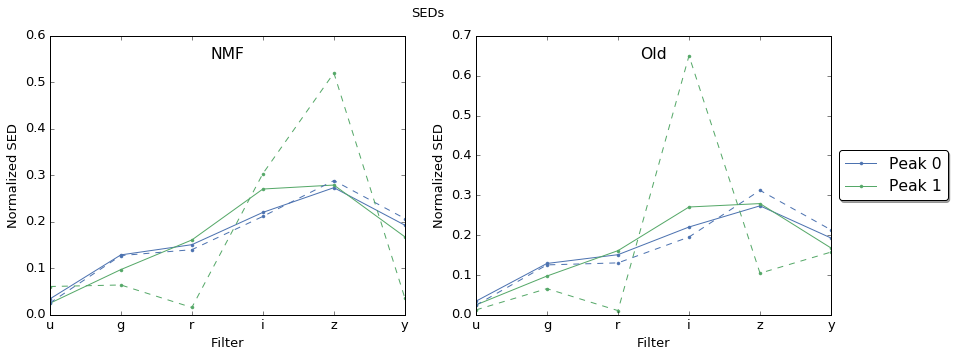

In [10]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
display.compareSeds([simTable, glmm.seds], filters, ax=ax1, show=False)
display.compareSeds([simTable, peakTable], filters, ax=ax2, show=False)
fig.suptitle("SEDs")
ax1.set_title("NMF", y=.9)
ax2.set_title("Old", y=.9)
plt.legend(loc="center left", fancybox=True, shadow=True, ncol=1, bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
simFullTemplates = sim.getSimTemplates(simTable, filters, display=False)
templates = OrderedDict([
    ("old", oldTemplates),
    #("new", debTemplates),
    ("new mono", newTemplates),
    ("new apportioned", newApportioned),
    ("sim", simFullTemplates),
])
allSources = sim.makeAllMeasurements(templates, filters, expDb.calexps, footprint, thresh=1e-13)

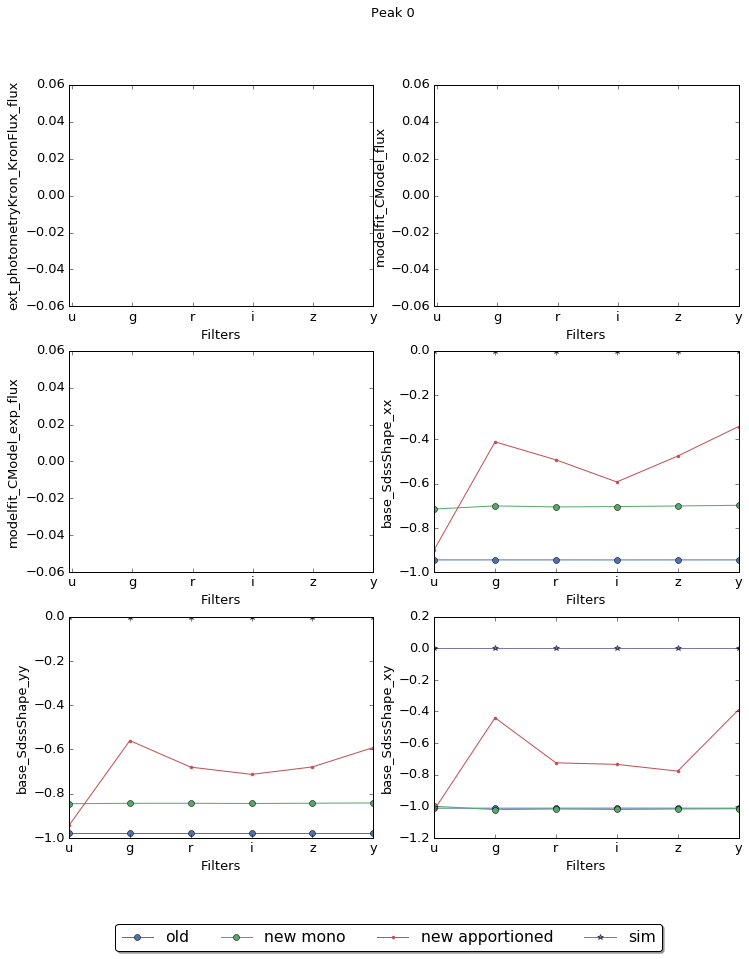

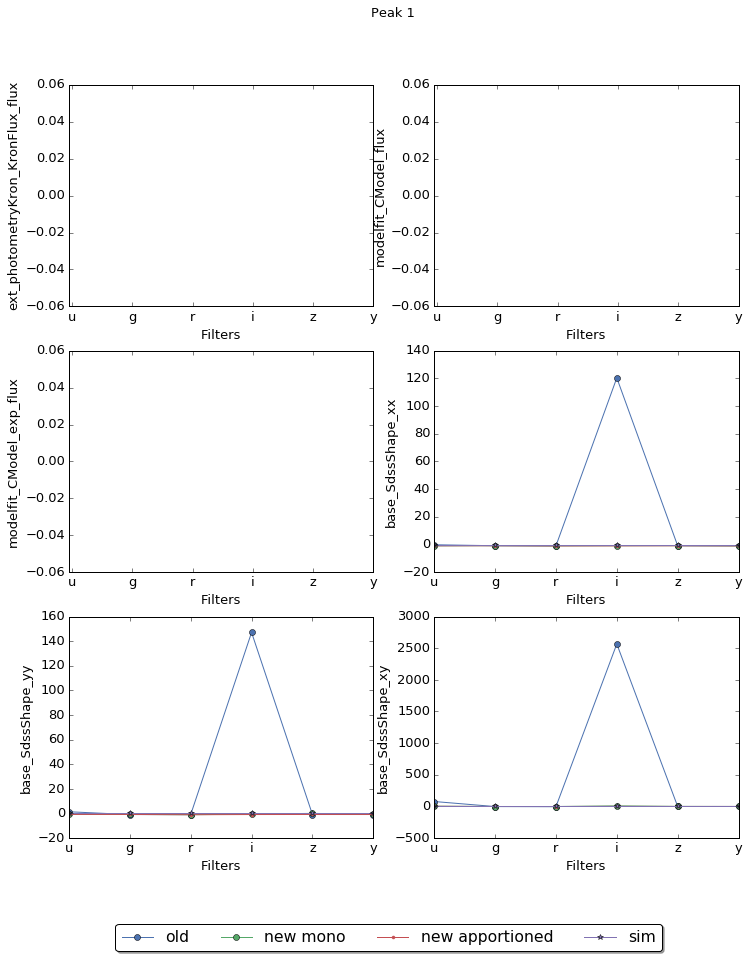

In [13]:
columns = [
    #"base_GaussianFlux_flux",
    "ext_photometryKron_KronFlux_flux",
    "modelfit_CModel_flux",
    "modelfit_CModel_exp_flux",
    "base_SdssShape_xx",
    "base_SdssShape_yy",
    "base_SdssShape_xy",
]

for pk, src in enumerate(allSources["sim"][filters[0]]):
    sim.compareSourceColumns(allSources, columns, pk, filters=filters)

INFO:lsst.meas.deblender:Old Deblender Comparison


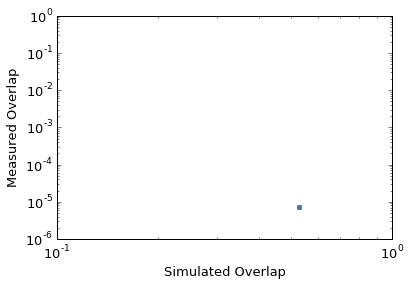

INFO:lsst.meas.deblender:NMF Deblender Comparison


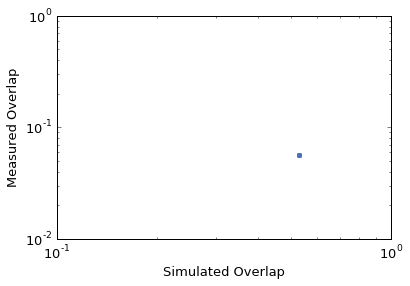

INFO:lsst.meas.deblender:NMF Deblender Reapportioned


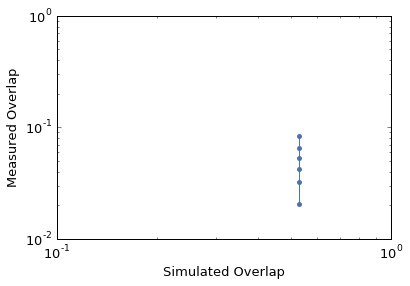

In [15]:
logger.info("Old Deblender Comparison")
ss, ds = sim.compareOverlap(simTemplates, oldTemplates, show=False)
logger.info("NMF Deblender Comparison")
ss, ds = sim.compareOverlap(simTemplates, newTemplates, show=False)
logger.info("NMF Deblender Reapportioned")
ss, ds = sim.compareOverlap(simTemplates, newApportioned, show=False)

In [18]:
import imp
imp.reload(sim)
imp.reload(debUtils)
imp.reload(display)
#allSources = sim.makeAllMeasurements(templates, filters, expDb.calexps, footprint, thresh=1e-13, config=config)

<module 'lsst.meas.deblender.display' from '/Users/fred/lsst/code/meas_deblender/python/lsst/meas/deblender/display.py'>

In [23]:
templates["sim"].shape

(2, 6, 251, 251)

In [60]:
maxFlux = np.sum(simTemplates, axis=(2,3))

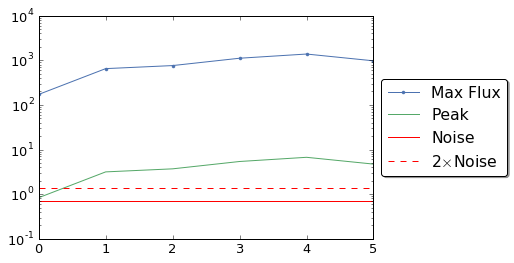

In [72]:
plt.semilogy(maxFlux[0,:], '.-', label="Max Flux")
plt.semilogy(np.max(simTemplates[0], axis=(1,2)), label="Peak")
plt.semilogy(avgNoise, 'r', label="Noise")
plt.semilogy(2*np.array(avgNoise), 'r--', label="2$\\times$Noise")
plt.legend(loc='center left', bbox_to_anchor=(1, .5),
                   fancybox=True, shadow=True)